# Lab 4: Diputados üê∑

In [1]:
from IPython.display import HTML
import random

def hide(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Mostrar C√≥digo'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide()

<img src='https://images-na.ssl-images-amazon.com/images/I/91Mk%2BWYjgIL._SL1500_.jpg'>

El objetivo de este lab es que pongas en pr√°ctica tus habilidades de recopilaci√≥n de datos usando web scraping, as√≠ como tu capacidad de analizar dichos datos ya que la informaci√≥n se ecuentra estructurada.

## Instrucciones
Desarrolla un programa que recopile la informaci√≥n de cada disputado listado en la p√°gina de gobernaci√≥n: http://sitl.diputados.gob.mx/LXIV_leg/listado_diputados_buscador.php y recopila la siguiente informaci√≥n:

* Nombre del diputado
* Entidad que representa
* Partido pol√≠tico
* Correo electr√≥nico
* Nivel de escolaridad (secundaria, preparatoria, universidad, maestr√≠a, doctorado)
* Iniciativas presentadas y estatus ante el Pleno (Tipo de presentaci√≥n, totales y aprobadas)

Una vez que tengas toda la informaci√≥n capturada en dataframe haz un an√°lisis basado en las siguientes puntos (tu puedes proponer m√°s):
* Cantidad de diputados por partido pol√≠tico
* Niveles de escolaridad
* Niveles de escolaridad por partido pol√≠tico
* ¬øC√≥mo se ve la cantidad de propuestas realizadas y aprobadas con respecto a?:
    * Partido pol√≠tico
    * Escolaridad

Nota: Acompa√±a tus an√°lisis con plots que nutran tu an√°lisis

## Contenido 

* An√°lisis 
* Web Scraping
* Imports

In [2]:
## all imports
from IPython.display import HTML
import numpy as np
import urllib
import bs4 #this is beautiful soup
import time
import operator
import socket
import re # regular expressions
from urllib.request import urlopen

from pandas import Series
import pandas as pd  #USED
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

import requests

#from selenium import webdriver  #VER DIFERENCIA DESPUES
from bs4 import BeautifulSoup #USED


import requests 

import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')
hide()

# An√°lisis

### Cargar Datos

In [3]:
df = pd.read_csv('Diputados.csv')
df["Partido"]= df["Partido"].replace('logo_SP.jpg', "Sin Partido") 
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
df.head()

Nombre   Entidad           Partido  \
0        Pedro Daniel Abasolo S√°nchez   M√©xico             MORENA   
1          Brasil Alberto Acosta Pe√±a   M√©xico                PRI   
2              Miguel Acundo Gonz√°lez   Puebla   Encuentro Social   
3        Marco Antonio Adame Castillo  Morelos                PAN   
4  Heriberto Marcelo Aguilar Castillo   Sonora             MORENA   

                                Correo    Escolaridad  \
0      pedro.abasolo@diputados.gob.mx      Secundaria   
1      brasil.acosta@diputados.gob.mx       Doctorado   
2      miguel.acundo@diputados.gob.mx   Sin registros   
3        marco.adame@diputados.gob.mx        Maestr√≠a   
4  heriberto.aguilar@diputados.gob.mx    Licenciatura   

   Total de Iniciativas Presentadas  Total de Iniciativas Aprobadas  \
0                                16                              10   
1                                45                               3   
2                                24                               3   
3                               121                               6   
4                                23                              10   

   i Grupos Parlamentarios P  i Grupos Parlamentarios A  i de Grupo P  \
0                          0                          0            15   
1                          0                          0             1   
2                          1                          1             5   
3                          2                          0            27   
4                          1                          0            15   

   i de Grupo A  i Iniciante P  i Iniciante A  i Adherente P  i Adherente A  
0            10              0              0              1              0  
1             0              1              0             43              3  
2             1              7              0             11              1  
3             1              5              0             87              5  
4            10              0              0              7              0

## Diputados por Partido 

In [13]:
dfDiputadosPorPartido = df.groupby('Partido')[['Nombre']].count().reset_index()
dfDiputadosPorPartido.columns=['Partido', 'Cantidad']
dfDiputadosPorPartido = dfDiputadosPorPartido.sort_values('Cantidad', ascending = False)

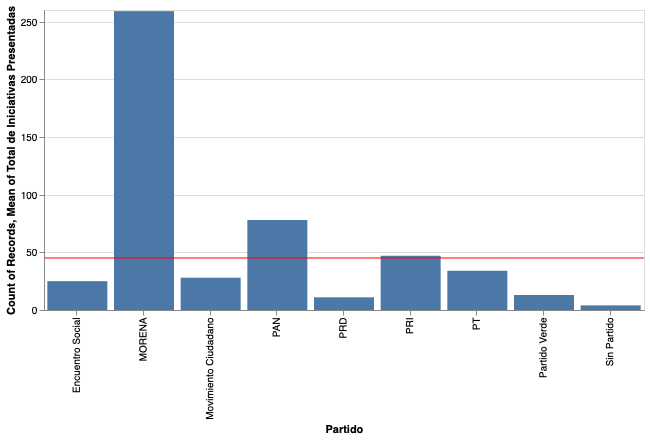

In [6]:
source = df

bar = alt.Chart(source).mark_bar().encode(
    x='Partido:O',
    y='count(Nombre):Q'
)

rule = alt.Chart(source).mark_rule(color='red').encode(
    y='mean(Total de Iniciativas Presentadas):Q'
)

(bar + rule).properties(width=600)


In [26]:
import plotly.offline as pyo
import plotly.graph_objs as go

colors = ['rgb(147, 9, 21)','rgb(20, 39, 232)','rgb(4, 117, 6 )','rgb(247, 0, 0  )','rgb(247, 120, 0)',
         'rgb(139, 0, 247  )','rgb(19, 214, 0  )','rgb(244, 247, 0  )','rgb(97, 107, 107)'] 

fig = go.Figure(data=[go.Bar(
    x= dfDiputadosPorPartido.Partido,
    y= dfDiputadosPorPartido.Cantidad,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(
    title=go.layout.Title(
    text='N√∫mero de Diputados por Partido Pol√≠tico'
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="",
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="N√∫mero de Diputados",
        )
    )
)

In [49]:
import plotly.graph_objects as go
animals=['giraffes', 'orangutans', 'monkeys']

fig = go.Figure([go.Bar(x=animals, y=[20, 14, 23])])
fig.show()

In [17]:
dfDiputadosPorPartido.columns

Index(['TotalDiputados'], dtype='object')

In [68]:





dfPigs = df
dfPigs

Unnamed: 0                                   Nombre            Entidad  \
0             1             Pedro Daniel Abasolo S√°nchez            M√©xico    
1             2               Brasil Alberto Acosta Pe√±a            M√©xico    
2             3                   Miguel Acundo Gonz√°lez            Puebla    
3             4             Marco Antonio Adame Castillo           Morelos    
4             5       Heriberto Marcelo Aguilar Castillo            Sonora    
5             6                 Ricardo Aguilar Castillo            M√©xico    
6             7                  Bonifacio Aguilar Linda          Veracruz    
7             8            Leticia Arlett Aguilar Molina           Chiapas    
8             9                      Marcos Aguilar Vega         Quer√©taro    
9            10                  Adriana Aguilar V√°zquez   San Luis Potos√≠    
10           11                Sebasti√°n Aguilera Brenes         Chihuahua    
11           12                 Maribel Aguilera Chairez           Durango    
12           13            Jos√© Guadalupe Aguilera Rojas         Michoac√°n    
13           14                       Aleida Alavez Ruiz  Ciudad de M√©xico    
14           15                     Abril Alcal√° Padilla           Jalisco    
15           16             Jes√∫s Sergio Alc√°ntara N√∫√±ez            M√©xico    
16           17               Luis Javier Alegre Salazar      Quintana Roo    
17           18            Maximino Alejandro Candelaria  Ciudad de M√©xico    
18           19                  Nohem√≠ Alem√°n Hern√°ndez        Tamaulipas    
19           20              Mar√≠a Alem√°n Mu√±oz Castillo         Quer√©taro    
20           21              Mar√≠a Isabel Alfaro Morales           Hidalgo    
21           22             Ma. Guadalupe Almaguer Pardo   San Luis Potos√≠    
22           23             Karla Yuritzi Almaz√°n Burgos            M√©xico    
23           24                     M√≥nica Almeida L√≥pez           Jalisco    
24           25               Mar√≠a Ester Alonzo Morales           Yucat√°n    
25           26        Mar√≠a Guillermina Alvarado Moreno        Nuevo Le√≥n    
26           27            Ivonne Liliana √Ålvarez Garc√≠a        Nuevo Le√≥n    
27           28           Jos√© Guadalupe Ambrocio Gachuz           Morelos    
28           29              Socorro Irma Andazola G√≥mez   Baja California    
29           30             Marco Antonio Andrade Zavala           Chiapas    
..          ...                                      ...                ...   
469         470           Lidia Nallely Vargas Hern√°ndez   San Luis Potos√≠    
470         471           Teresita de Jes√∫s Vargas Meraz         Chihuahua    
471         472                  Alfredo Vazquez Vazquez           Chiapas    
472         473     Marcela Guillermina Velasco Gonz√°lez            M√©xico    
473         474                  Mar√≠a Luisa Veloz Silva   San Luis Potos√≠    
474         475          Julieta Kristal Vences Valencia            Puebla    
475         476          Vicente Javier Verastegui Ostos        Tamaulipas    
476         477               Jes√∫s Carlos Vidal Peniche           Yucat√°n    
477         478               Alejandro Viedma Vel√°zquez            M√©xico    
478         479                   Alberto Villa Villegas           Jalisco    
479         480                 Lilia Villafuerte Zavala        Guanajuato    
480         481           Mirtha Iliana Villalvazo Amaya           Nayarit    
481         482       Roc√≠o del Pilar Villarauz Mart√≠nez  Ciudad de M√©xico    
482         483                Ricardo Villarreal Garc√≠a        Guanajuato    
483         484       Francisco Jorge Villarreal Pasaret         Chihuahua    
484         485           Juan Carlos Villarreal Salazar           Jalisco    
485         486        Silvia Lorena Villavicencio Ayala  Ciudad de M√©xico    
486         487                 Alfredo Villegas Arreola           Sinaloa  

In [69]:
dfPigs['animal'] = 'pigs'

In [70]:
dfPigs

Unnamed: 0                                   Nombre            Entidad  \
0             1             Pedro Daniel Abasolo S√°nchez            M√©xico    
1             2               Brasil Alberto Acosta Pe√±a            M√©xico    
2             3                   Miguel Acundo Gonz√°lez            Puebla    
3             4             Marco Antonio Adame Castillo           Morelos    
4             5       Heriberto Marcelo Aguilar Castillo            Sonora    
5             6                 Ricardo Aguilar Castillo            M√©xico    
6             7                  Bonifacio Aguilar Linda          Veracruz    
7             8            Leticia Arlett Aguilar Molina           Chiapas    
8             9                      Marcos Aguilar Vega         Quer√©taro    
9            10                  Adriana Aguilar V√°zquez   San Luis Potos√≠    
10           11                Sebasti√°n Aguilera Brenes         Chihuahua    
11           12                 Maribel Aguilera Chairez           Durango    
12           13            Jos√© Guadalupe Aguilera Rojas         Michoac√°n    
13           14                       Aleida Alavez Ruiz  Ciudad de M√©xico    
14           15                     Abril Alcal√° Padilla           Jalisco    
15           16             Jes√∫s Sergio Alc√°ntara N√∫√±ez            M√©xico    
16           17               Luis Javier Alegre Salazar      Quintana Roo    
17           18            Maximino Alejandro Candelaria  Ciudad de M√©xico    
18           19                  Nohem√≠ Alem√°n Hern√°ndez        Tamaulipas    
19           20              Mar√≠a Alem√°n Mu√±oz Castillo         Quer√©taro    
20           21              Mar√≠a Isabel Alfaro Morales           Hidalgo    
21           22             Ma. Guadalupe Almaguer Pardo   San Luis Potos√≠    
22           23             Karla Yuritzi Almaz√°n Burgos            M√©xico    
23           24                     M√≥nica Almeida L√≥pez           Jalisco    
24           25               Mar√≠a Ester Alonzo Morales           Yucat√°n    
25           26        Mar√≠a Guillermina Alvarado Moreno        Nuevo Le√≥n    
26           27            Ivonne Liliana √Ålvarez Garc√≠a        Nuevo Le√≥n    
27           28           Jos√© Guadalupe Ambrocio Gachuz           Morelos    
28           29              Socorro Irma Andazola G√≥mez   Baja California    
29           30             Marco Antonio Andrade Zavala           Chiapas    
..          ...                                      ...                ...   
469         470           Lidia Nallely Vargas Hern√°ndez   San Luis Potos√≠    
470         471           Teresita de Jes√∫s Vargas Meraz         Chihuahua    
471         472                  Alfredo Vazquez Vazquez           Chiapas    
472         473     Marcela Guillermina Velasco Gonz√°lez            M√©xico    
473         474                  Mar√≠a Luisa Veloz Silva   San Luis Potos√≠    
474         475          Julieta Kristal Vences Valencia            Puebla    
475         476          Vicente Javier Verastegui Ostos        Tamaulipas    
476         477               Jes√∫s Carlos Vidal Peniche           Yucat√°n    
477         478               Alejandro Viedma Vel√°zquez            M√©xico    
478         479                   Alberto Villa Villegas           Jalisco    
479         480                 Lilia Villafuerte Zavala        Guanajuato    
480         481           Mirtha Iliana Villalvazo Amaya           Nayarit    
481         482       Roc√≠o del Pilar Villarauz Mart√≠nez  Ciudad de M√©xico    
482         483                Ricardo Villarreal Garc√≠a        Guanajuato    
483         484       Francisco Jorge Villarreal Pasaret         Chihuahua    
484         485           Juan Carlos Villarreal Salazar           Jalisco    
485         486        Silvia Lorena Villavicencio Ayala  Ciudad de M√©xico    
486         487                 Alfredo Villegas Arreola           Sinaloa  

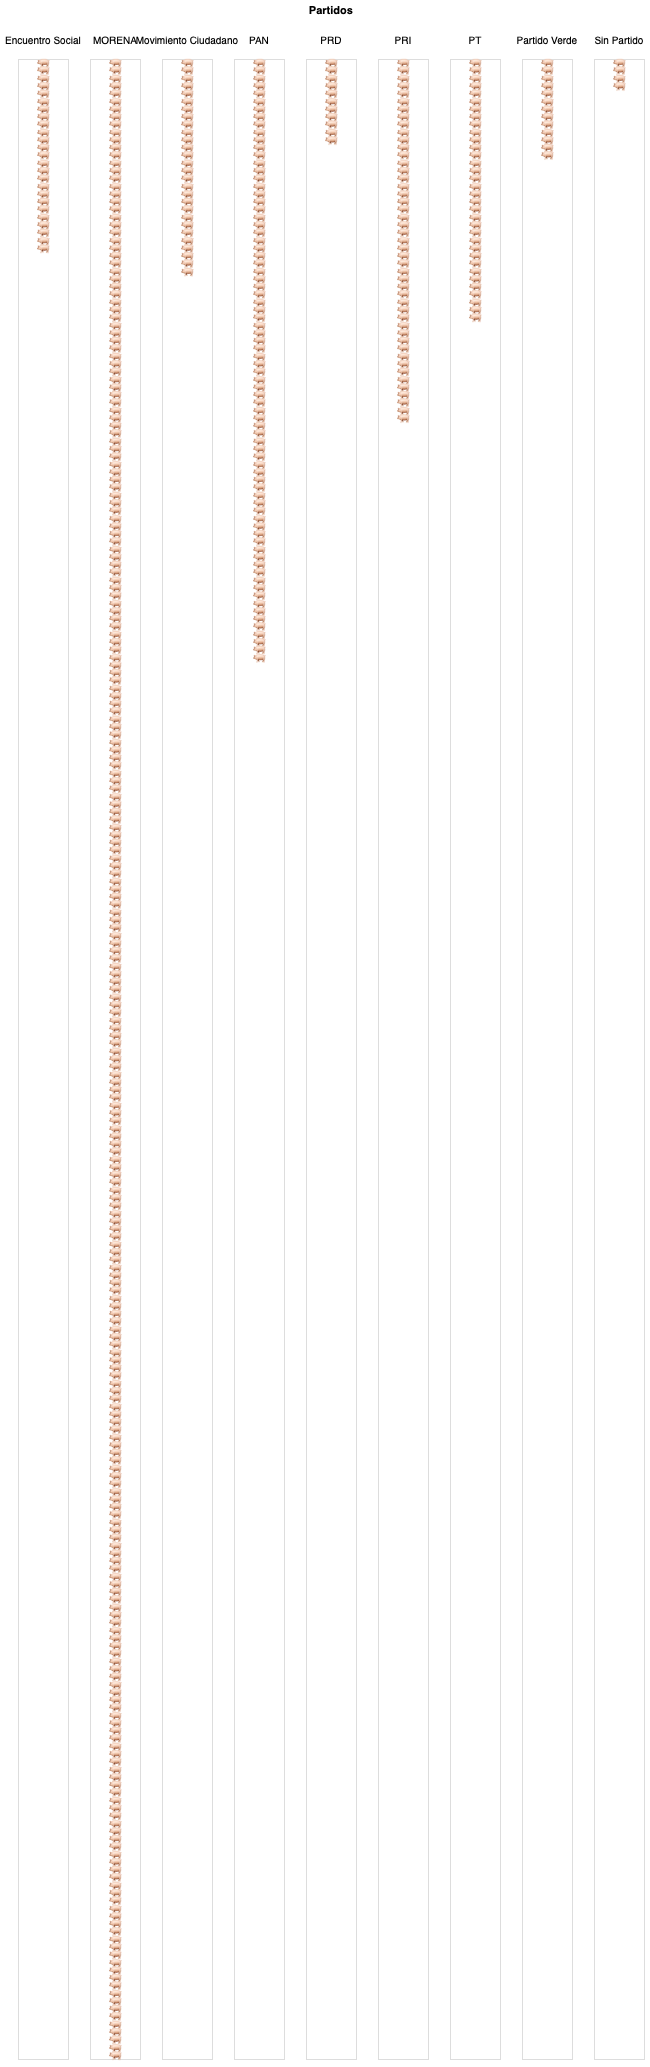

In [71]:
alt.Chart(dfPigs).mark_text(size=10, baseline='middle').encode(
    alt.X('animal:O', axis=None),
    alt.Y('y:O', axis=None),
    alt.Column('Partido:N', header=alt.Header(title='Partidos')),
    alt.Text('emoji:N')
).transform_calculate(
    emoji="{'pigs': 'üêñ'}[datum.animal]"
).transform_window(
    y='rank()',
    groupby=['Partido', 'animal']
).properties(width=50, height=2000)

# Escolaridad por Partido Pol√≠tico

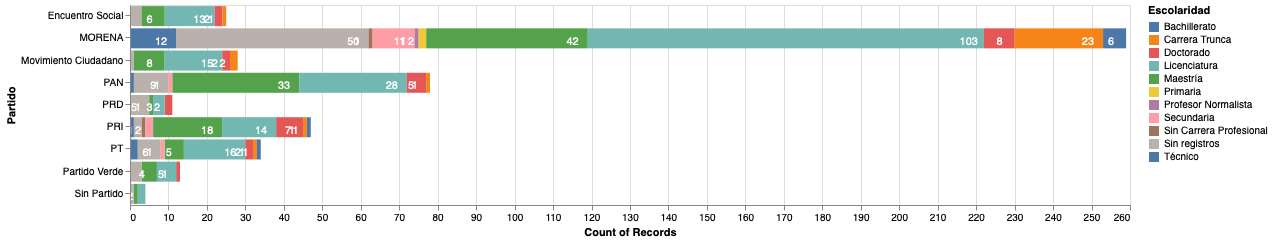

In [72]:
bars = alt.Chart(df).mark_bar().encode(
    x=alt.X('count(Nombre):Q', stack='zero'),
    y=alt.Y('Partido:N'),
    color=alt.Color('Escolaridad')
).properties(width=1000, height=200)

text = alt.Chart(df).mark_text(dx=-15, dy=3, color='white').encode(
    x=alt.X('count(Nombre):Q', stack='zero'),
    y=alt.Y('Partido:N'),
    detail='Escolaridad:N',
    text=alt.Text('count(Nombre):Q')
)

bars + text

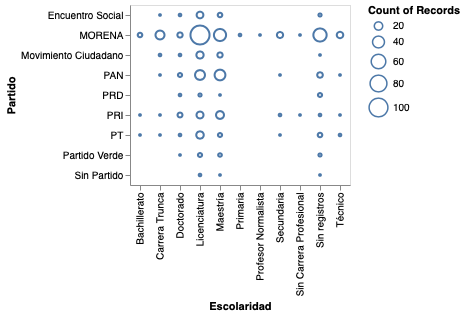

In [73]:
alt.Chart(df).mark_point().encode(
    x='Escolaridad',
    y='Partido',
    size='count(Nombre)'
)

In [74]:
df['Escolaridad'].value_counts()

Licenciatura               199
Maestr√≠a                   118
Sin registros               80
Doctorado                   29
Carrera Trunca              29
T√©cnico                     16
Secundaria                  15
Bachillerato                 8
Sin Carrera Profesional      2
Primaria                     2
Profesor Normalista          1
Name: Escolaridad, dtype: int64

# Propuestas realizadas por Partido Politico y Escolaridad

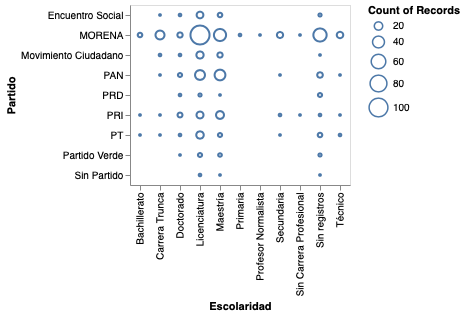

In [75]:
alt.Chart(df).mark_point().encode(
    x='Escolaridad',
    y='Partido',
    size='count(Total de Iniciativas Presentadas)'
)

# Propuestas aprobadas por Partido Politico y Escolaridad

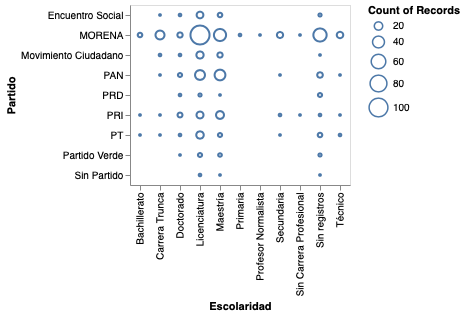

In [76]:
alt.Chart(df).mark_point().encode(
    x='Escolaridad',
    y='Partido',
    size='count(Total de Iniciativas Aprobadas)'
)

In [77]:
source

Unnamed: 0                                   Nombre            Entidad  \
0             1             Pedro Daniel Abasolo S√°nchez            M√©xico    
1             2               Brasil Alberto Acosta Pe√±a            M√©xico    
2             3                   Miguel Acundo Gonz√°lez            Puebla    
3             4             Marco Antonio Adame Castillo           Morelos    
4             5       Heriberto Marcelo Aguilar Castillo            Sonora    
5             6                 Ricardo Aguilar Castillo            M√©xico    
6             7                  Bonifacio Aguilar Linda          Veracruz    
7             8            Leticia Arlett Aguilar Molina           Chiapas    
8             9                      Marcos Aguilar Vega         Quer√©taro    
9            10                  Adriana Aguilar V√°zquez   San Luis Potos√≠    
10           11                Sebasti√°n Aguilera Brenes         Chihuahua    
11           12                 Maribel Aguilera Chairez           Durango    
12           13            Jos√© Guadalupe Aguilera Rojas         Michoac√°n    
13           14                       Aleida Alavez Ruiz  Ciudad de M√©xico    
14           15                     Abril Alcal√° Padilla           Jalisco    
15           16             Jes√∫s Sergio Alc√°ntara N√∫√±ez            M√©xico    
16           17               Luis Javier Alegre Salazar      Quintana Roo    
17           18            Maximino Alejandro Candelaria  Ciudad de M√©xico    
18           19                  Nohem√≠ Alem√°n Hern√°ndez        Tamaulipas    
19           20              Mar√≠a Alem√°n Mu√±oz Castillo         Quer√©taro    
20           21              Mar√≠a Isabel Alfaro Morales           Hidalgo    
21           22             Ma. Guadalupe Almaguer Pardo   San Luis Potos√≠    
22           23             Karla Yuritzi Almaz√°n Burgos            M√©xico    
23           24                     M√≥nica Almeida L√≥pez           Jalisco    
24           25               Mar√≠a Ester Alonzo Morales           Yucat√°n    
25           26        Mar√≠a Guillermina Alvarado Moreno        Nuevo Le√≥n    
26           27            Ivonne Liliana √Ålvarez Garc√≠a        Nuevo Le√≥n    
27           28           Jos√© Guadalupe Ambrocio Gachuz           Morelos    
28           29              Socorro Irma Andazola G√≥mez   Baja California    
29           30             Marco Antonio Andrade Zavala           Chiapas    
..          ...                                      ...                ...   
469         470           Lidia Nallely Vargas Hern√°ndez   San Luis Potos√≠    
470         471           Teresita de Jes√∫s Vargas Meraz         Chihuahua    
471         472                  Alfredo Vazquez Vazquez           Chiapas    
472         473     Marcela Guillermina Velasco Gonz√°lez            M√©xico    
473         474                  Mar√≠a Luisa Veloz Silva   San Luis Potos√≠    
474         475          Julieta Kristal Vences Valencia            Puebla    
475         476          Vicente Javier Verastegui Ostos        Tamaulipas    
476         477               Jes√∫s Carlos Vidal Peniche           Yucat√°n    
477         478               Alejandro Viedma Vel√°zquez            M√©xico    
478         479                   Alberto Villa Villegas           Jalisco    
479         480                 Lilia Villafuerte Zavala        Guanajuato    
480         481           Mirtha Iliana Villalvazo Amaya           Nayarit    
481         482       Roc√≠o del Pilar Villarauz Mart√≠nez  Ciudad de M√©xico    
482         483                Ricardo Villarreal Garc√≠a        Guanajuato    
483         484       Francisco Jorge Villarreal Pasaret         Chihuahua    
484         485           Juan Carlos Villarreal Salazar           Jalisco    
485         486        Silvia Lorena Villavicencio Ayala  Ciudad de M√©xico    
486         487                 Alfredo Villegas Arreola           Sinaloa  

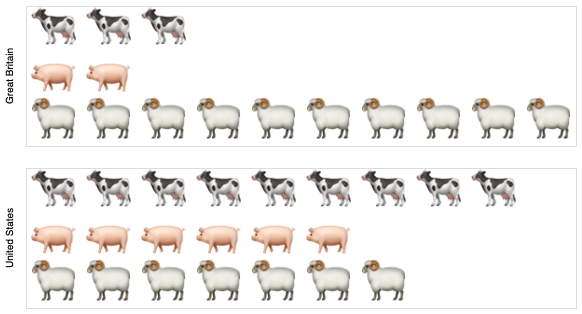

In [78]:
import altair as alt
alt.renderers.enable('notebook')

source = pd.DataFrame([
      {'country': 'Great Britain', 'animal': 'cattle'},
      {'country': 'Great Britain', 'animal': 'cattle'},
      {'country': 'Great Britain', 'animal': 'cattle'},
      {'country': 'Great Britain', 'animal': 'pigs'},
      {'country': 'Great Britain', 'animal': 'pigs'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'}
    ])


alt.Chart(source).mark_text(size=45, baseline='middle').encode(
    alt.X('x:O', axis=None),
    alt.Y('animal:O', axis=None),
    alt.Row('country:N', header=alt.Header(title='')),
    alt.Text('emoji:N')
).transform_calculate(
    emoji="{'cattle': 'üêÑ', 'pigs': 'üêñ', 'sheep': 'üêè'}[datum.animal]"
).transform_window(
    x='rank()',
    groupby=['country', 'animal']
).properties(width=550, height=140)

chromedriver = "/Users/jaimesolis/Downloads/chromedriver-2"
driver = webdriver.Chrome(chromedriver)
driver.get("https://google.com")


#### BeautifulSoup Object

In [79]:
import requests 

In [80]:
r = requests.get('http://sitl.diputados.gob.mx/LXIV_leg/listado_diputados_buscador.php')

In [81]:
from bs4 import BeautifulSoup 
soup = BeautifulSoup(r.text, 'html.parser') 

In [82]:
print (soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script language="JavaScript" src="./javascripts/anim_imag.js" type="text/javascript">
  </script>
  <link href="./include/styles_diputados.css" rel="stylesheet" type="text/css"/>
  <link href="./include/formatonvo.css" rel="stylesheet" type="text/css"/>
  <title>
   Listado de Diputados LXIV
  </title>
 </head>
 <body leftmargin="0" topmargin="0">
  <table align="center" border="0" cellpadding="0" cellspacing="0">
   <tr>
    <td>
     <tr>
      <td valign="top" width="760">
       <img border="0" height="115" src="images/cabezalLXIV.png" width="760"/>
      </td>
     </tr>
     <tr>
      <td colspan="3">
       <table border="0" cellpadding="0" cellspacing="0" width="760">
        <tr>
         <td align="center" bgcolor="#595843" class="textoBlanco" width="175">
          24/09/2019
         

## Lista de elementos donde esta el sublink

In [83]:
lista1 = soup.find_all('a', attrs={'class':'linkVerde'}) #Obtiene el elemento donde esta el link
del lista1[0] #borramamos el primero que encuentra <a class="linkVerde" href="info_diputados.php">Regresar</a>
len(lista1) #Verificar que tenemos 499 elementos

499

### Test para obtener el primer link

In [84]:
test = lista1[0] #Probar antes de hacer loop
testlink = test['href'] #devuelve curricula.php?dipt=484 de href="curricula.php?dipt=484

## Lista de Sublinks 

In [85]:
links = []
for element in lista1:
    link = element['href']
    links.append(link)

In [86]:
len(links)

499

### Test para obtener la info del primero diputado

In [87]:
r = requests.get('http://sitl.diputados.gob.mx/LXIV_leg/' + testlink )
soup2 = BeautifulSoup(r.text, 'html.parser')
print(soup2.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script language="JavaScript" src="./javascripts/anim_imag.js" type="text/javascript">
  </script>
  <link href="./include/styles_diputados.css" rel="stylesheet" type="text/css"/>
  <link href="./include/formatonvo.css" rel="stylesheet" type="text/css"/>
  <title>
   Curricula LXIV
  </title>
  <style>
   .fondoimg {
background:url(images/fondo_fot_5.png) no-repeat center fixed;
-webkit-background-size: cover;
-moz-background-size: cover;
-o-background-size: cover;
background-size: cover;
}
.fondoimg2 {
background-image: url(images/fondo_fot_7.png);
  -webkit-background-size: 100% 100%;           /* Safari 3.0 */
     -moz-background-size: 100% 100%;           /* Gecko 1.9.2 (Firefox 3.6) */
       -o-background-size: 100% 100%;           /* Opera 9.5 */
          background-size: 100% 100%;       

#### NOMBRE

In [88]:
elemento = soup2.find('td',{'class': 'textocurrienc', 'height': '23'}) 
elemento

<td class="textocurrienc" colspan="2" height="23"><center><strong>Dip. Pedro Daniel Abasolo S√°nchez</strong></center></td>

In [89]:
testNombre = elemento.center.strong.text[5:]
testNombre

'Pedro Daniel Abasolo S√°nchez'

#### ENTIDAD

In [90]:
soup2.find_all('td', {'width': '470', 'class':'textocurri'})

[<td class="textocurri" width="470"><strong>Representaci√≥n proporcional</strong></td>,
 <td class="textocurri" width="470"><strong>M√©xico </strong>
 
 ¬†¬†¬†<b>|</b>¬†¬†Circunscripci√≥n:  ¬†
 <strong>5 </strong>
 
 ¬†¬†¬†<b>|</b>¬†¬†¬†</td>,
 <td class="textocurri" width="470"><strong>pedro.abasolo@diputados.gob.mx </strong></td>,
 <td class="textocurri" width="470"><strong>3-febrero </strong></td>,
 <td class="textocurri" width="470">Carlos Alejandro Mendoza √Ålvarez
 					
 
 
  </td>]

In [91]:
elemento = soup2.find_all('td', {'width': '470', 'class':'textocurri'})
elemento = elemento[1]
elemento


<td class="textocurri" width="470"><strong>M√©xico </strong>

¬†¬†¬†<b>|</b>¬†¬†Circunscripci√≥n:  ¬†
<strong>5 </strong>

¬†¬†¬†<b>|</b>¬†¬†¬†</td>

In [92]:
elemento.strong.text

'M√©xico '

In [93]:
testEntidad = elemento.strong.text
testEntidad

'M√©xico '

#### PARTIDO POLITICO

In [94]:
elemento = soup2.find('img', {'width': '80'})
elemento

<img height="80" src="images/LogoMorena.jpg" width="80"/>

In [95]:
elemento['src']

'images/LogoMorena.jpg'

In [96]:
testPartido= elemento['src']
testPartido = testPartido[7:]
testPartido

'LogoMorena.jpg'

#### CORREO ELECTRONICO 

In [97]:
soup2.find_all('td', {'width': '470', 'class': 'textocurri'})

[<td class="textocurri" width="470"><strong>Representaci√≥n proporcional</strong></td>,
 <td class="textocurri" width="470"><strong>M√©xico </strong>
 
 ¬†¬†¬†<b>|</b>¬†¬†Circunscripci√≥n:  ¬†
 <strong>5 </strong>
 
 ¬†¬†¬†<b>|</b>¬†¬†¬†</td>,
 <td class="textocurri" width="470"><strong>pedro.abasolo@diputados.gob.mx </strong></td>,
 <td class="textocurri" width="470"><strong>3-febrero </strong></td>,
 <td class="textocurri" width="470">Carlos Alejandro Mendoza √Ålvarez
 					
 
 
  </td>]

In [98]:
elemento = soup2.find_all('td', {'width': '470', 'class': 'textocurri'})
elemento = elemento[2]
elemento

<td class="textocurri" width="470"><strong>pedro.abasolo@diputados.gob.mx </strong></td>

In [99]:
testCorreo =elemento.strong.text
testCorreo

'pedro.abasolo@diputados.gob.mx '

#### Escolaridad

Encontrar tag de Escolaridad y si lo encuentra encontrar el maximo nivel de estudios

Si tiene escolaridad, buscar el nivel m√°ximo que tenga. 

In [100]:
#elemento = soup2.find('td', {'class':'TitulosVerde'})
elemento = soup2.find(text='ESCOLARIDAD')
print(elemento)
#elemento.text

ESCOLARIDAD


In [101]:
if soup2.find(text='ESCOLARIDAD'):
    elementoEscolaridad = soup2.find('td', {'class':'TitulosVerde'}).findNext('td')
    testEscolaridad = elementoEscolaridad.text
else: 
    testEscolaridad = 'Sin registros'
testEscolaridad

'Secundaria'

In [102]:
if soup2.find(text='Doctorado'):
    testEscolaridad = 'Doctorado'
elif soup2.find(text='Maestr√≠a'):
    testEscolaridad = 'Maestr√≠a'
elif soup2.find(text='Licenciatura'):
    testEscolaridad = 'Licenciatura'
elif soup2.find(text='Bachillerato'):
    testEscolaridad = 'Bachillerato'
elif soup2.find(text='Secundaria'):
    testEscolaridad = 'Secundaria'
elif soup2.find(text='Primaria'):
    testEscolaridad = 'Secundaria'
elif soup2.find(text='ESCOLARIDAD'):
    elementoEscolaridad = soup2.find('td', {'class':'TitulosVerde'}).findNext('td')
    testEscolaridad = elementoEscolaridad.text
else: 
    testEscolaridad = 'Sin registros'
testEscolaridad

'Secundaria'

#### PROPUESTAS POR TIPO

In [103]:
r3 = requests.get('http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=282')
soup3 = BeautifulSoup(r3.text, 'html.parser')

In [104]:
soup2.find_all(text='Tipo de presentaci√≥n')

['Tipo de presentaci√≥n', 'Tipo de presentaci√≥n']

In [105]:
test=soup2.find_all(text='Tipo de presentaci√≥n')
test = test[1] #el segundo porque el primero es otra parte que no es visible 
propuestas = test.findNext('tr')
propuestas

<tr bgcolor="#E3DAC1">
<td align="center" class="textoNegro" width="150">Adherente</td>
<td align="center" bgcolor="#cccccc" class="textoNegro" width="100">1 </td>
<td align="center" class="textoNegro" width="100"><b>0</b></td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>0</b> </td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>1</b></td>
<tr bgcolor="#FFFFFF">
<td align="center" class="textoNegro" width="150">De Grupo</td>
<td align="center" bgcolor="#cccccc" class="textoNegro" width="100">15 </td>
<td align="center" class="textoNegro" width="100"><b>10</b></td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>0</b> </td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>5</b></td>
</tr>
<tr bgcolor="#E3DAC1">
<td align="center" class="te

##### a) Diversos Grupos Parlamentarios

In [106]:
if propuestas.find(text='Diversos Grupos Parlamentarios'):
    ElementoGruposParlamentariosP = propuestas.find(text='Diversos Grupos Parlamentarios')
    ElementoGruposParlamentariosA = ElementoGruposParlamentariosT.findNext('td')
    
    testGruposParlamentariosP = int(ElementoGruposParlamentariosP.findNext('td').text)
    testGruposParlamentariosA = int(ElementoGruposParlamentariosA.findNext('td').text)
else: 
    testGruposParlamentariosP = 0
    testGruposParlamentariosA = 0

In [107]:
testGruposParlamentariosP

0

##### b) De grupo

In [108]:
if propuestas.find(text='De Grupo'):
    ElementoDeGrupoP = propuestas.find(text='De Grupo')
    ElementoDeGrupoA = ElementoDeGrupoP.findNext('td')
    
    testDeGrupoP = int(ElementoDeGrupoP.findNext('td').text)
    testDeGrupoA = int(ElementoDeGrupoA.findNext('td').text)
else: 
    testDeGrupoP = 0
    testDeGrupoA = 0

In [109]:
print(testDeGrupoA)

10


##### c) Iniciante

In [110]:
if propuestas.find(text='Iniciante'):
    ElementoInicianteP = propuestas.find(text='Iniciante')
    ElementoInicianteA = ElementoInicianteT.findNext('td')
    
    testInicianteP = int(ElementoInicianteP.findNext('td').text)
    testInicianteA = int(ElementoInicianteA.findNext('td').text)
else: 
    testInicianteP = 0
    testInicianteA = 0

##### d) Adherente 

In [111]:
if propuestas.find(text='Adherente'):
    ElementoAdherenteP = propuestas.find(text='Adherente')
    ElementoAdherenteA = ElementoAdherenteP.findNext('td')
    
    testAdherenteP = int(ElementoAdherenteP.findNext('td').text)
    testAdherenteA = int(ElementoAdherenteA.findNext('td').text)
else: 
    testAdherenteP = 0
    testAdherenteA = 0

#### Totales

In [112]:
testTotalesP=testGruposParlamentariosP+testDeGrupoP+testInicianteP+testAdherenteP
testTotalesA=testGruposParlamentariosA+testDeGrupoA+testInicianteA+testAdherenteA


Como ya funcionan los test de un diputado, podemos proceder a hacerlo con todos

# Scraping de Diputados

In [ ]:
df = pd.DataFrame(data, columns=['Nombre','Entidad','Partido','Correo','Escolaridad',
                                 'Total de Iniciativas Presentadas','Total de Iniciativas Aprobadas',
                                 'i Grupos Parlamentarios P', 'i Grupos Parlamentarios A','i de Grupo P', 
                                 'i de Grupo A', 'i Iniciante P', 'i Iniciante A', 'i Adherente P', 'i Adherente A'])

### Limpiar nombres de Partidos

In [ ]:
df["Partido"]= df["Partido"].replace('LogoMorena.jpg', "MORENA") 
df["Partido"]= df["Partido"].replace('pri01.png', "PRI") 
df["Partido"]= df["Partido"].replace('encuentro.png', "Encuentro Social") 
df["Partido"]= df["Partido"].replace('pan.png', "PAN") 
df["Partido"]= df["Partido"].replace('prd01.png', "PRD") 
df["Partido"]= df["Partido"].replace('logvrd.jpg', "Partido Verde") 
df["Partido"]= df["Partido"].replace('Logo_PT.png', "PT") 
df["Partido"]= df["Partido"].replace('logo_movimiento_ciudadano.png', "Movimiento Ciudadano") 
df


In [ ]:
index=list(range(1,500))
df.index = index

In [ ]:
df.groupby('Partido')['Nombre'].count()

In [ ]:
df[df['Partido']=='logo_SP.jpg']

In [ ]:
df["Partido"]= df["Partido"].replace('logo_SP.jpg', "Sin Partido") 

In [ ]:
df[['Nombre', 'Escolaridad']].head(100)

### Limpiar Escolaridad

In [ ]:
df["Escolaridad"]= df["Escolaridad"].replace('Bachillerato ', "Bachillerato") 

In [ ]:
dfEscolaridadLimpiar = df[['Nombre', 'Escolaridad']][(df['Escolaridad']!= 'Doctorado') & 
                                                     (df['Escolaridad']!= 'Maestr√≠a') & 
                                                     (df['Escolaridad']!= 'Licenciatura') & 
                                                     (df['Escolaridad']!= 'Bachillerato') & 
                                                     (df['Escolaridad']!= 'Secundaria') & 
                                                     (df['Escolaridad']!= 'Primaria') & 
                                                     (df['Escolaridad']!= 'Carrera Trunca') & 
                                                      (df['Escolaridad']!= 'T√©cnico') & 
                                                     (df['Escolaridad']!= 'Sin registros')]
dfEscolaridadLimpiar

In [ ]:
df["Escolaridad"]= df["Escolaridad"].replace('Bachillerato | Nivel Medio Superior', "Bachillerato") 

In [ ]:
df.set_value(24, 'Escolaridad', 'Sin Carrera Profesional') 
df.set_value(53, 'Escolaridad', 'Licenciatura') 
df.set_value(263, 'Escolaridad', 'Profesor Normalista') 
df.set_value(359, 'Escolaridad', 'Sin Carrera Profesional') 

In [ ]:
pd.crosstab(df['Escolaridad'], 'Numero de diputados').sort_values(by=['Numero de diputados'], ascending=False)

In [ ]:
df.to_csv('Diputados.csv')